In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.linalg as la
import math
#import time
from numpy import random
import cmath
from sympy import S, symbols, printing

from compilers import *
#import openfermion

import json


## Hamiltonian Initialization

#### Arbitrary Tensored 4x4 Pauli

In [2]:
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
Y = np.array([[0, -1j],
     [1j, 0]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)
IX = np.kron(I, X)
XI = np.kron(X, I)
IZ = np.kron(I, Z)
ZI = np.kron(Z, I)
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ, IX, IZ, XI, ZI])
hj = [1.0, 2.0, -3.0, -4.0, -2.0, 1.0, 0.5, 0.25] #list of normalized coefficients

print(Hlist.shape)

hamiltonian_list = []
for i in range(len(hj)):
    hamiltonian_list.append(hj[i] * Hlist[i, :, :])
hamiltonian_list = np.array(hamiltonian_list)
pauli_hamiltonian = hamiltonian_list
print(hamiltonian_list.shape)
#print(hamiltonian_list)

(8, 4, 4)
(8, 4, 4)


#### Graph Hamiltonian

In [3]:
# A simple function that computes the graph distance between two sites
def dist(site1, site2):
    distance_vec = site1 - site2
    distance = np.abs(distance_vec[0]) + np.abs(distance_vec[1])
    return distance

# A simple function that initializes a graph in the form of an np.array of coordinates 
def initialize_graph(x_sites, y_sites):
    coord_list = []
    for i in range(x_sites):
        for j in range(y_sites):
            coord_list.append([i,j])
    return np.array(coord_list)

#A funciton that initializes a Pauli operator in the correct space, acting on a specific qubit
def initialize_operator(operator_2d, acting_space, space_dimension):
    if acting_space>space_dimension:
        return 'error'
    for i in range(acting_space):
        operator_2d = np.kron(operator_2d, I)
    for j in range(space_dimension - acting_space-1):
        operator_2d = np.kron(I, operator_2d)
    return operator_2d

In [20]:
#Initialize Hamiltonian 
def graph_hamiltonian(x_dim, y_dim, rng_seed):
    np.random.seed(rng_seed)
    hamiltonian_list = []
    graph = initialize_graph(x_dim, y_dim)
    for i in range(x_dim*y_dim):
        for j in range(y_dim*x_dim):
            if i != j: #long range interaction
                alpha = np.random.normal()
                hamiltonian_list.append(alpha * 
                    np.matmul(initialize_operator(Z, i, x_dim*y_dim), initialize_operator(Z, j, x_dim*y_dim)) *
                        10.0**(-dist(graph[i], graph[j]))) 

            # if (dist(graph[i], graph[j])==1) and (i>j): #nearest neighbour interaction
            #     beta = np.random.normal()
            #     hamiltonian_list.append(beta * np.matmul(initialize_operator(Y, i, x_dim*y_dim), initialize_operator(Y, j, x_dim*y_dim)))
            
        gamma = np.random.normal()
        hamiltonian_list.append(4* gamma * initialize_operator(X, i, x_dim*y_dim))
                
    return np.array(hamiltonian_list)

graph_hamiltonian_list = graph_hamiltonian(3, 2, 1)
print(graph_hamiltonian_list.shape)

(36, 64, 64)


### OpenFermion Hamiltonian List Generators

In [47]:
from openfermion.hamiltonians import jellium_model
from openfermion.utils import Grid, count_qubits
from openfermion.transforms import jordan_wigner, fourier_transform, get_fermion_operator
from openfermion.linalg import eigenspectrum, qubit_operator_sparse, get_sparse_operator
from openfermion.ops import QubitOperator

#A function to help convert from the default output of openfermion to the style we require to run our simulator, 
# a numpy array that is structured as a list of hamiltonian terms. 
def openfermion_matrix_list(qubit_operator):
    total_qubits = count_qubits(qubit_operator)
    matrix_list = []
    op_list = list(qubit_operator)
    for i in op_list:
        matrix_list.append(get_sparse_operator(i, total_qubits).toarray()) #changed from qubit operator and made no differnce
    return np.array(matrix_list)

    #Test -- shows ops are equivalent
def test_list_generator(openfermion_output):
    max_val = []
    of_generator = get_sparse_operator(openfermion_output).toarray()
    list_generator = sum(openfermion_matrix_list(openfermion_output))
    the_zero_op = of_generator - list_generator
    for i in range(the_zero_op.shape[0]):
        for j in range(the_zero_op.shape[0]):
            max_val.append((the_zero_op)[i][j])
    print(max(max_val))
    norm = np.linalg.norm(the_zero_op, ord=2)
    if norm < FLOATING_POINT_PRECISION:
        print("success!")
    else:
        print("failed!")
    return 0

ImportError: cannot import name 'comb' from 'scipy.misc' (/opt/anaconda3/lib/python3.7/site-packages/scipy/misc/__init__.py)

#### Jellium

In [13]:
#small model in 2 dimensions
grid = Grid(dimensions=1, length=5, scale=1.0)
spinless = True

# Get the momentum Hamiltonian.
momentum_hamiltonian = jellium_model(grid, spinless)
momentum_qubit_operator = jordan_wigner(momentum_hamiltonian)
momentum_qubit_operator.compress()

#Generate the matrix list
jellium_hamiltonian_list = openfermion_matrix_list(momentum_qubit_operator) #load this into simulator
print(jellium_hamiltonian_list.shape)
print(momentum_qubit_operator)
test_list_generator(momentum_qubit_operator)

(56, 32, 32)
98.19868481373146 [] +
0.029841551829730383 [X0 X1 X2 X3] +
-0.029841551829730383 [X0 X1 X2 Z3 X4] +
0.029841551829730383 [X0 X1 Y2 Y3] +
0.029841551829730383 [X0 X1 Y2 Z3 Y4] +
0.029841551829730383 [X0 X1 X3 X4] +
0.029841551829730383 [X0 X1 Y3 Y4] +
0.029841551829730383 [X0 Y1 X2 Y3] +
-0.029841551829730383 [X0 Y1 X2 Z3 Y4] +
-0.029841551829730383 [X0 Y1 Y2 X3] +
-0.029841551829730383 [X0 Y1 Y2 Z3 X4] +
0.029841551829730383 [X0 Y1 X3 Y4] +
-0.029841551829730383 [X0 Y1 Y3 X4] +
-0.029841551829730383 [X0 Z1 X2 X3 X4] +
0.029841551829730383 [X0 Z1 X2 Y3 Y4] +
-0.029841551829730383 [X0 Z1 Y2 X3 Y4] +
-0.029841551829730383 [X0 Z1 Y2 Y3 X4] +
-0.029841551829730383 [Y0 X1 X2 Y3] +
-0.029841551829730383 [Y0 X1 X2 Z3 Y4] +
0.029841551829730383 [Y0 X1 Y2 X3] +
-0.029841551829730383 [Y0 X1 Y2 Z3 X4] +
-0.029841551829730383 [Y0 X1 X3 Y4] +
0.029841551829730383 [Y0 X1 Y3 X4] +
0.029841551829730383 [Y0 Y1 X2 X3] +
0.029841551829730383 [Y0 Y1 X2 Z3 X4] +
0.029841551829730383 [Y0 Y1 Y2 

0

#### LiH, Methane, and Ethane

In [ ]:
from openfermion.chem import MolecularData
from openfermionpsi4 import run_psi4

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.2
n_points = 10

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(1, n_points + 1):
    bond_length = bond_length_interval * float(point)
    bond_lengths += [bond_length]
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))
    
    # Run Psi4.
    molecule = run_psi4(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)

    # Print out some results of calculation.
    print('\nAt bond length of {} angstrom, molecular hydrogen has:'.format(
        bond_length))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
        molecule.nuclear_repulsion))
    for orbital in range(molecule.n_orbitals):
        print('Spatial orbital {} has energy of {} Hartree.'.format(
            orbital, molecule.orbital_energies[orbital]))
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]

# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [14]:
from openfermion.chem import geometry_from_pubchem
from openfermion.chem import MolecularData

basis = 'sto-3g'
multiplicity = 1

# Set Hamiltonian parameters.
active_space_start = 1
active_space_stop = 3

In [15]:
#LiH
#LiH_geometry = geometry_from_pubchem('LiH')
diatomic_bond_length = 1.45
LiH_geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
print(LiH_geometry)

# Generate and populate instance of MolecularData.
LiH_molecule = MolecularData(LiH_geometry, basis, multiplicity, description="1.45")
LiH_molecule.load()

# Get the Hamiltonian in an active space.
LiH_molecular_hamiltonian = LiH_molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

# Map operator to fermions and qubits.
LiH_fermion_hamiltonian = get_fermion_operator(LiH_molecular_hamiltonian)
LiH_qubit_hamiltonian = jordan_wigner(LiH_fermion_hamiltonian)
LiH_hamiltonian_list = openfermion_matrix_list(LiH_qubit_hamiltonian)
print(LiH_hamiltonian_list.shape)
#print(list(LiH_qubit_hamiltonian))
#print(LiH_hamiltonian_list)
test_list_generator(LiH_qubit_hamiltonian)

[('Li', (0.0, 0.0, 0.0)), ('H', (0.0, 0.0, 1.45))]
(27, 16, 16)
(8.881784197001252e-16+0j)
success!


0

In [16]:
#METHANE
methane_geometry = geometry_from_pubchem('methane')
print(methane_geometry)

# Generate and populate instance of MolecularData.
methane_molecule = MolecularData(methane_geometry, basis, multiplicity, description="1.45")
methane_molecule.load()

# Get the Hamiltonian in an active space.
methane_molecular_hamiltonian = methane_molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

# Map operator to fermions and qubits.
methane_fermion_hamiltonian = get_fermion_operator(methane_molecular_hamiltonian)
methane_qubit_hamiltonian = jordan_wigner(methane_fermion_hamiltonian)
methane_hamiltonian_list = openfermion_matrix_list(methane_qubit_hamiltonian)
print(methane_hamiltonian_list.shape)
print(methane_hamiltonian_list)

[('C', (0, 0, 0)), ('H', (0.5541, 0.7996, 0.4965)), ('H', (0.6833, -0.8134, -0.2536)), ('H', (-0.7782, -0.3735, 0.6692)), ('H', (-0.4593, 0.3874, -0.9121))]


OSError: Unable to open file (unable to open file: name = '/opt/anaconda3/lib/python3.7/site-packages/openfermion/testing/data/H4-C1_sto-3g_singlet_1.45.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
#ETHANE
ethane_geometry = geometry_from_pubchem('ethane')
print(ethane_geometry)

# Generate and populate instance of MolecularData.
ethane_molecule = MolecularData(ethane_geometry, basis, multiplicity, description="1.45")
ethane_molecule.load()

# Get the Hamiltonian in an active space.
ethane_molecular_hamiltonian = ethane_molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

# Map operator to fermions and qubits.
ethane_fermion_hamiltonian = get_fermion_operator(ethane_molecular_hamiltonian)
ethane_qubit_hamiltonian = jordan_wigner(ethane_fermion_hamiltonian)
ethane_hamiltonian_list = openfermion_matrix_list(ethane_qubit_hamiltonian)
print(ethane_hamiltonian_list.shape)
print(ethane_hamiltonian_list)

## Notebook using compilers.py

The goal is to compare the functions in compilers.py in both output and runtimes. The only part of the previous sections that this section will reference is "Hamiltonian Initialization"

### Trotter Simulation

In [61]:
sim1 = TrotterSim(hamiltonian_list, order = 2)
#sim1.initial_state = InitialState

In [62]:
iterations = 1
tStart = 0.01
tFinal = 0.5
tSteps = 50
times = np.geomspace(tStart, tFinal, tSteps)

trot_compiler_inf = []
for t in times:
    trot_compiler_inf.append(sim1.infidelity(t, iterations))

log_trot_compiler_inf = np.log10(trot_compiler_inf)
log_times = np.log10(times)
print(log_trot_compiler_inf.shape)
print(sim1.gate_count)

(50,)
16


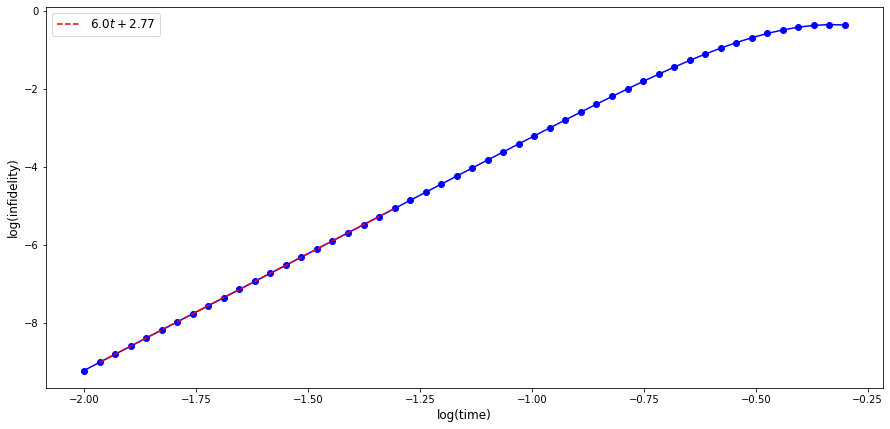

In [63]:
#data = log_trot_compiler_inf[:, 0, 0]
data = log_trot_compiler_inf
plt.figure(figsize = (15, 7))
plt.plot(log_times, data, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points= 1  #declare the starting point to fit in the data
end_fit_points = -30

p = np.polyfit(log_times[start_fit_points: end_fit_points], data[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

### QDrift Simulation

In [5]:
QDsim = QDriftSim(hamiltonian_list, rng_seed=1)

In [6]:
samples = 20
mc_samples = 200

tStart = 0.001
tFinal = 1
tSteps = 20
times = np.geomspace(tStart, tFinal, tSteps) 

qd_compiler_inf = []
for t in times:
    qd_compiler_inf.append(QDsim.sample_channel_inf(t, samples, mc_samples))

log_qd_compiler_inf = np.log10(qd_compiler_inf)
log_times = np.log10(times)
print(log_qd_compiler_inf.shape)
print(QDsim.gate_count)
#print(QDsim.exp_op_cache)

(20,)
20


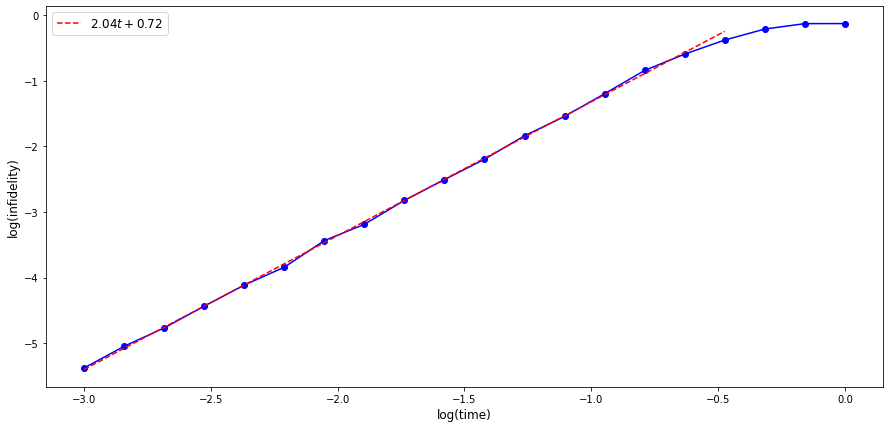

In [7]:
data1 = log_qd_compiler_inf #[:, 0, 0]
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points=0  #declare the starting point to fit in the data
end_fit_points = -4

p = np.polyfit(log_times[start_fit_points: end_fit_points], data1[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

### Composite Simulation

##### Time Scaling

In [5]:
#Warning if nb_optimizer = True for partition attribute optimize the computation will not finish in your lifetime
CompSim = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition = "optimal chop", weight_threshold = 0.1, nb = 8, nb_optimizer = False, initial_time = 0.1, epsilon = 0.05)
#CompSim.simulate(0.1, 8, 2)
CompSim.repartition(1)

Iteration No: 1 started. Evaluating function at random point.
0.06005008287140301 18 4
the upper bound is 4
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.1032
Function value obtained: 24.5346
Current minimum: 24.5346
Iteration No: 2 started. Evaluating function at random point.
SAMPLE COUNT: 8
[sim_channel_performance] Iterations too large, already below error threshold
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1882
Function value obtained: 11.0000
Current minimum: 11.0000
Iteration No: 3 started. Evaluating function at random point.
the upper bound is 2
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2445
Function value obtained: 18.0000
Current minimum: 11.0000
Iteration No: 4 started. Evaluating function at random point.
SAMPLE COUNT: 8
[sim_channel_performance] Iterations too large, already below error threshold
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0709
Function value obtained

KeyboardInterrupt: 

In [ ]:
print(CompSim.optimized_gatecost)
print(CompSim.nb)

0
8


In [ ]:
#startTime = time.time()

iterations = 10
qd_samples = 8
mc_samples = 100

tStart = 0.001
tFinal = 0.5
tSteps = 40
times = np.geomspace(tStart, tFinal, tSteps)

comp_compiler_inf = []
for t in times:
    comp_compiler_inf.append(CompSim.sample_channel_inf(t, qd_samples, iterations, mc_samples, exact_time_evolution(CompSim.unparsed_hamiltonian, t, CompSim.initial_state)))

log_comp_compiler_inf = np.log10(comp_compiler_inf)
log_times = np.log10(times)
print(log_comp_compiler_inf.shape)
print(CompSim.gate_count)

#executionTime = (time.time() - startTime)
#print('Execution time in seconds: ' + str(executionTime))

(40,)
80


8


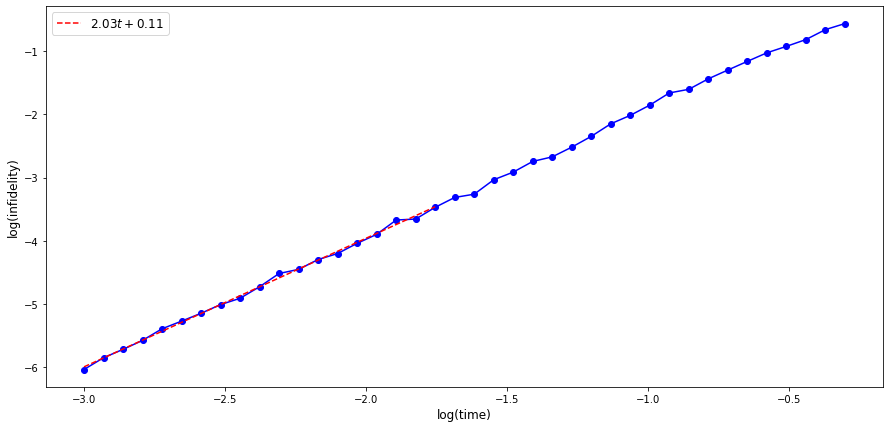

In [ ]:
print(CompSim.nb)
data1 = log_comp_compiler_inf #this dimension issue might be causing some slow down
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points=0  #declare the starting point to fit in the data
end_fit_points = -22

p = np.polyfit(log_times[start_fit_points: end_fit_points], data1[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

#plt.ylim(-1.1, -0.8)
#plt.locator_params('x', nbins=20)
plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

#### Channel Gate Performance using sim_channel_performance()

In [ ]:
#Load sims and test Monte-Carlo
CompSim1 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, initial_time=0.1, partition="prob", nb = 2, nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
TrotSim1 = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="trotter", nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
TrotSim2 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, partition="trotter", nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
QDSim1  = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="qdrift", nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)

t = 0.1
samples = 120
iterations = 1
sample_guess = 4
mcsamples = 200
#mcsamples = QDSim1.sample_decider(t, samples, iterations, sample_guess) #needs to be evaluated in a region known to be convergent
print(mcsamples)

Nb is 16
There are 12 terms in Trotter
There are 13 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
There are 0 terms in Trotter
There are 25 terms in QDrift
200


In [ ]:
data1 = CompSim1.sim_channel_performance(t, samples, iterations, mcsamples)
#data2 = TrotSim1.sim_channel_performance(t, samples, iterations, mcsamples)
#data3 = TrotSim2.sim_channel_performance(t, samples, iterations, mcsamples)
#data4 = QDSim1.sim_channel_performance(t, samples, iterations, mcsamples)
#print('We require ' + str(data2)  +' gates to meet an epsilon of ' + str(CompSim1.epsilon))

[sim_channel_performance] Iterations too large, already below error threshold


In [ ]:
print(data1, len(CompSim1.a_norms), len(CompSim1.b_norms))
plt.figure(figsize = (15, 7))
plt.plot(QDSim1.gate_data[:,0], QDSim1.gate_data[:,1], 'go-') 
plt.xlabel('gate count', size = 12)
plt.ylabel('infidelity', size = 12)

start_fit_points=0  #declare the starting point to fit in the data
end_fit_points = -1
order = 1

p = np.polyfit(QDSim1.gate_data[:,0][start_fit_points: end_fit_points], QDSim1.gate_data[:,1][start_fit_points: end_fit_points], order)
f = np.poly1d(p)

t_new = np.linspace(QDSim1.gate_data[:,0][start_fit_points], QDSim1.gate_data[:,0][end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

#plt.ylim(-1.1, -0.8)
#plt.locator_params('x', nbins=20)
plt.plot(t_new, y_new, 'b--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

144 12 13


TypeError: list indices must be integers or slices, not tuple

<Figure size 1080x504 with 0 Axes>

### Long Sim Analyzer

In [14]:
#beware of runtime
iterations = 1
samples = 1
mc_samples = 150

tStart = 0.1
tFinal = 5
tSteps = 10
times = np.geomspace(tStart, tFinal, tSteps)

CompSim = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, initial_time=0.1, partition="optimal chop", nb=12, nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
TrotSim1 = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="trotter", epsilon=0.05)
TrotSim2 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, partition="trotter", epsilon=0.05)
QDSim  = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="qdrift", epsilon=0.05)

CompSim_results = dict()
TrotSim1_results = dict()
TrotSim2_results = dict()
QDSim_results = dict()

partition_dist = [] #partition distribution

for t in times:
    #CompSim.repartition(t)
    #CompSim_results[t] = CompSim.sim_channel_performance(t, samples, iterations, mc_samples) #uncomment for non-optimized methods
    
    CompSim.time = t
    CompSim.repartition(t)
    CompSim_results[t] = CompSim.optimized_gatecost
    partition_dist.append([len(CompSim.a_norms), len(CompSim.b_norms)])
    TrotSim1_results[t] = TrotSim1.sim_channel_performance(t, samples, iterations, mc_samples)
    TrotSim2_results[t] = TrotSim2.sim_channel_performance(t, samples, iterations, mc_samples)
    print("AT TIME " + str(t))

for t in times[:12]:
    QDSim_results[t] = QDSim.sim_channel_performance(t, samples, iterations, mc_samples)
    print("AT QD TIME " + str(t))

partition_dist = np.array(partition_dist)

outfile = open("sim_channel_performance_with_optimized_repartitioning_June_03.json", "w")
json.dump(CompSim_results, outfile)
json.dump(TrotSim1_results, outfile)
json.dump(TrotSim2_results, outfile)
json.dump(QDSim_results, outfile)
outfile.close()
    

Iteration No: 1 started. Evaluating function at random point.
the upper bound is 2
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6974
Function value obtained: 26.0000
Current minimum: 26.0000
Iteration No: 2 started. Evaluating function at random point.
SAMPLE COUNT: 12
[sim_channel_performance] Iterations too large, already below error threshold
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1023
Function value obtained: 15.0000
Current minimum: 15.0000
Iteration No: 3 started. Evaluating function at random point.
the upper bound is 2
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2942
Function value obtained: 26.0000
Current minimum: 15.0000
Iteration No: 4 started. Evaluating function at random point.
SAMPLE COUNT: 12
[sim_channel_performance] Iterations too large, already below error threshold
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1000
Function value obtained: 15.0000
Current minim

KeyboardInterrupt: 

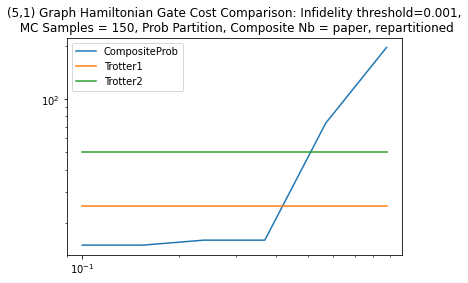

In [17]:

plt.title("(5,1) Graph Hamiltonian Gate Cost Comparison: Infidelity threshold=0.001,\n MC Samples = 150, Prob Partition, Composite Nb = paper, repartitioned")
plt.loglog(times[:6], list(CompSim_results.values()), label="CompositeProb")
plt.loglog(times[:6], list(TrotSim1_results.values()), label="Trotter1")
plt.loglog(times[:6], list(TrotSim2_results.values()), label="Trotter2")
#plt.loglog(times[:12], list(QDSim_results.values()), label="QDrift")
plt.legend()
plt.show()

TypeError: list indices must be integers or slices, not tuple

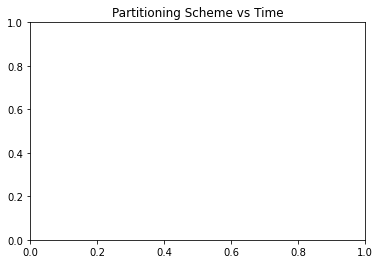

In [ ]:
plt.title("Partitioning Scheme vs Time")
plt.plot(times, partition_dist[:,0], label="TrotterTerms")
plt.plot(times, partition_dist[:,1], label = "QDrift Terms")
#plt.plot(times, partition_dist[:,0]/partition_dist[:,1], label = "A/B ratio")
plt.legend()
plt.show

##### Gate Infidelity Scaling

In this section we are evaluating the gate performance to achieve an infidelity of at most `0.05`, which corresponds to a fidelity of at least `0.95`. We initially develop our benchmarks with the simple pauli hamiltonian. For Trotter we can determine the number of gates fairly easily, but for the other two channels there are a few possible points of randomization which make this harder:
* Number of QDrift samples (NB)
* Monte carlo sampling due to using vectors as opposed to density matrices
* Additional sampling may be required if using a probabilistic partition.

Due to this randomization we need to introduce another arbitrary metric to evaluate how confident we are that the emprical mean infidelity is above this threshold. Since we have no estimates for the true variance of our infidelity estimator, we have to rely on the sample variance which introduces yet another point of decision as we have to set a limit for how many samples must be taken. Our way around this is that we want our empirical mean to be high enough that if we were to take a gaussian `g` with the empirical mean `m` and the empirical variance `v` then we want `Pr[x > 0.95] > 0.99`, where `x ~ g`. This corresponds to our empiric mean being at least two standard deviations above 0.95 (this is incorrect with `Pr[x > 0.95] > 0.99` but this way is simpler until i compute real number of standard devs needed). This might be absurdly costly to achieve and may need to be relaxed. This still leaves the question, how many samples are needed and how do we split with QD and MC?

The below section is aimed at understanding how many gates are needed for Trotter, QDrift, and Composite to hit our infidelity targets with the pauli hamiltonian and `t=1`. We also only compare low order trotter and use first order trotter for our composite channel. 

In [ ]:
t = 1.
first_order_trott = TrotterSim(pauli_hamiltonian, order=1)
second_order_trott = TrotterSim(pauli_hamiltonian, order=2)
qdrift_sim = QDriftSim(pauli_hamiltonian)
comp_high_thresh = CompositeSim(pauli_hamiltonian, partition="chop", weight_threshold=2.5)
comp_low_thresh = CompositeSim(pauli_hamiltonian, partition="chop", weight_threshold=0.6)


There are 2 terms in Trotter
There are 6 terms in QDrift
There are 6 terms in Trotter
There are 2 terms in QDrift


## WARNING: RUN AT YOUR OWN RISK: 223 MIN RUNTIME

In [ ]:
qdsim = QDriftSim(graph_hamiltonian_list)
compsim = CompositeSim(graph_hamiltonian_list, partition="chop", nb=8)
trottsim = TrotterSim(graph_hamiltonian_list)

tStart = 0.01
tFinal = 2
tSteps = 20
times = np.geomspace(tStart, tFinal, tSteps)

trott_results = dict()
qd_results = dict()
comp_results = dict()

for t in times:
    trott_results[t] = find_optimal_iterations(trottsim, graph_hamiltonian_list, time=t)
    qd_results[t] = find_optimal_iterations(qdsim, graph_hamiltonian_list, time=t, mc_samples=10)
    comp_results[t] = find_optimal_iterations(compsim, graph_hamiltonian_list, time=t, mc_samples=10)



There are 4 terms in Trotter
There are 12 terms in QDrift
[find_optimal_iterations] beginning search with lower, upper: 1 1
[find_optimal_iterations] iters: 1 , inf_mean:  4.981671053450043e-08  +- ( 0.0 )
[find_optimal_iterations] Average cost: 16.0
[find_optimal_iterations] beginning search with lower, upper: 1 1
[find_optimal_iterations] iters: 1 , inf_mean:  0.028213563545527908  +- ( 0.007971359885475959 )
[find_optimal_iterations] Average cost: 1.0
[find_optimal_iterations] beginning search with lower, upper: 1 1
[find_optimal_iterations] iters: 1 , inf_mean:  1.2972052589654836e-06  +- ( 7.208976705323271e-07 )
[find_optimal_iterations] Average cost: 5.0
[find_optimal_iterations] beginning search with lower, upper: 1 1
[find_optimal_iterations] iters: 1 , inf_mean:  1.5158060695519282e-07  +- ( 0.0 )
[find_optimal_iterations] Average cost: 16.0
[find_optimal_iterations] beginning search with lower, upper: 1 2
[find_optimal_iterations] iters: 2 , inf_mean:  0.019520610241073544  

In [ ]:
outfile = open("channel_gate_performanc_vs_time_MAR25_01.json", "w")
json.dump(trott_results, outfile)
json.dump(qd_results, outfile)
json.dump(comp_results, outfile)
outfile.close()

In [ ]:
trott_mean = []
trott_std = []
qd_mean = []
qd_std = []
comp_mean = []
comp_std = []

for t in times:
    trott_infs, trott_costs = zip(*trott_results.get(t))
    qd_infs, qd_costs = zip(*qd_results.get(t))
    comp_infs, comp_costs = zip(*comp_results.get(t))

    trott_mean.append(np.mean(list(trott_costs)))
    trott_std.append(np.std(list(trott_costs)))

    qd_mean.append(np.mean(list(qd_costs)))
    qd_std.append(np.std(list(qd_costs)))

    comp_mean.append(np.mean(list(comp_costs)))
    comp_std.append(np.std(list(comp_costs)))

print(len(qd_std))
print(len(comp_std))
print(len(trott_std))

plt.title("(4,1) Graph Hamiltonian Gate Cost Comparison: Infidelity threshold=0.05,\n MC Samples = 10, Chop Partition, Composite Nb = 8")
plt.loglog(times, trott_mean, label="Trotter")
plt.loglog(times, qd_mean, label="QDrift")
plt.loglog(times, comp_mean, label="Composite")
plt.legend()
plt.show()


NameError: name 'times' is not defined

## Code Profiling

In [ ]:
#Use the @profile decorator above any function in the notebook 
# and then simply execute the function from the classes defined below
QDtest = QDriftSim(graph_hamiltonian_list)
TrotTest = TrotterSim(graph_hamiltonian_list, order = 2)
CompTest = CompositeSim(graph_hamiltonian_list, inner_order =2, partition = "prob")

Nb is 28
There are 11 terms in Trotter
There are 5 terms in QDrift


In [ ]:
CompTest.simulate(1, 40, 500)

         218970 function calls (218942 primitive calls) in 0.653 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004    0.653    0.653 /Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/compilers.py:709(simulate)
      500    0.066    0.000    0.584    0.001 /Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/compilers.py:369(simulate)
      500    0.154    0.000    0.495    0.001 /Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/compilers.py:355(draw_hamiltonian_samples)
    14500    0.013    0.000    0.331    0.000 <__array_function__ internals>:2(sum)
16206/16179    0.013    0.000    0.327    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    14500    0.030    0.000    0

array([[ 0.04657303+8.98447138e-03j],
       [-0.0081226 -1.05209938e-01j],
       [ 0.00043893+4.53157983e-03j],
       [ 0.0104241 -1.15266977e-02j],
       [-0.03289562+1.12467799e-01j],
       [ 0.26043223+4.73684174e-03j],
       [-0.01007516-1.15135397e-03j],
       [ 0.01950316+2.80811059e-02j],
       [ 0.05212141-1.40581937e-01j],
       [-0.3312342 -2.74534659e-02j],
       [ 0.01443539-5.90420141e-04j],
       [-0.03004891-3.93644517e-02j],
       [ 0.34153119+1.03827494e-01j],
       [ 0.02018393-7.92414014e-01j],
       [-0.00339412+2.90928113e-02j],
       [ 0.08686583-6.11311439e-02j]])

### Density Matrix Sim

In [14]:
dms = DensityMatrixSim(hamiltonian_list = graph_hamiltonian_list, inner_order=2, outer_order=1, partition="chop", weight_threshold= 0.005, state_rand=True, pure=False)
#dms.sim_trace_distance(0.01, 11, 1)

mixed states not supported
There are 16 terms in Trotter
There are 9 terms in QDrift


In [15]:
iterations = 1
qd_samples = 20

tStart = 0.001
tFinal = 1
tSteps = 20
times = np.geomspace(tStart, tFinal, tSteps)

trace_distance = []
for t in times:
    trace_distance.append(dms.sim_trace_distance(t, qd_samples, iterations))

log_trace_distance = np.log10(trace_distance)
log_times = np.log10(times)
#print(log_trace_distance.shape)
print(dms.gate_count)

52


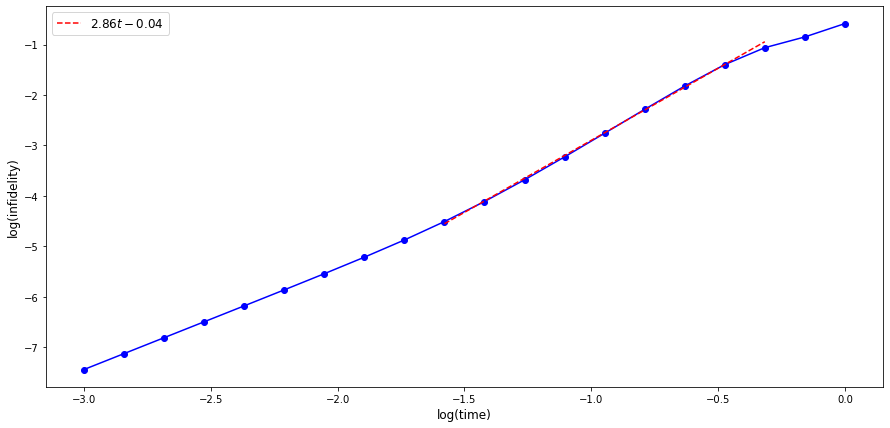

In [16]:
data1 = log_trace_distance #[:, 0, 0]
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points=9  #declare the starting point to fit in the data
end_fit_points = -3

p = np.polyfit(log_times[start_fit_points: end_fit_points], data1[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [18]:
#beware of runtime
tStart = 0.01/10
tFinal = 1.5/10
tSteps = 15
times = np.geomspace(tStart, tFinal, tSteps)

CompSim = DensityMatrixSim(graph_hamiltonian_list, inner_order=2, outer_order=1, initial_time=tStart, partition="prob", nb=15, nb_optimizer=False, weight_threshold=0.5, pure=False, epsilon=0.0001)
CompSim2 = DensityMatrixSim(graph_hamiltonian_list, inner_order=2, outer_order=1, initial_time=tStart, partition="prob", nb=15, nb_optimizer=True, weight_threshold=0.5, pure=False, epsilon=0.0001)
TrotSim1 = DensityMatrixSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="trotter", pure = True, epsilon=0.0001)
TrotSim2 = DensityMatrixSim(graph_hamiltonian_list, inner_order=2, outer_order=1, partition="trotter", pure = True, epsilon=0.0001)
QDSim  = DensityMatrixSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="qdrift", pure = False, epsilon=0.0001)

CompSim_results = dict()
CompSim2_results = dict()
TrotSim1_results = dict()
TrotSim2_results = dict()

partition_dist = [] #partition distribution
nb_t = []

for t in times:
    CompSim.time = t
    CompSim.repartition(t)
    CompSim_results[t] = CompSim.sim_channel_performance(t) #uncomment for non-optimized methods
    #CompSim_results[t] = CompSim.optimized_gatecost
    partition_dist.append([len(CompSim.a_norms), len(CompSim.b_norms)])
    nb_t.append(CompSim.nb)

    CompSim2.time = t
    CompSim2.repartition(t)
    CompSim2_results[t] = CompSim2.sim_channel_performance(t)
    #CompSim2_results[t] = CompSim2.optimized_gatecost
    partition_dist.append([len(CompSim2.a_norms), len(CompSim2.b_norms)])
    nb_t.append(CompSim2.nb)

    TrotSim1_results[t] = TrotSim1.sim_channel_performance(t)
    TrotSim2_results[t] = TrotSim2.sim_channel_performance(t)
    print("AT TIME " + str(t))


mixed states not supported
Nb is 11
There are 19 terms in Trotter
There are 24 terms in QDrift
mixed states not supported
Nb is 10
There are 43 terms in Trotter
There are 0 terms in QDrift
Nb is equal to 10
There are 43 terms in Trotter
There are 0 terms in QDrift
There are 43 terms in Trotter
There are 0 terms in QDrift
mixed states not supported
There are 0 terms in Trotter
There are 43 terms in QDrift
Nb is 11


/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


[sim_channel_performance] Iterations too large, already below error threshold
Nb is 10
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
AT TIME 0.001
Nb is 13
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 13
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
AT TIME 0.0014303261869275461
Nb is 15
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 15
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, alrea

In [13]:
QDSim_results = dict()
for t in times[:8]:
    QDSim_results[t] = QDSim.sim_channel_performance(t)
    print("AT QD TIME " + str(t))

partition_dist = np.array(partition_dist)
nb_t = np.array(nb_t)

outfile = open("sim_channel_performance_with_optimized_repartitioning_June_13.json", "w")
json.dump(CompSim_results, outfile)
json.dump(TrotSim1_results, outfile)
json.dump(TrotSim2_results, outfile)
json.dump(QDSim_results, outfile)
outfile.close()

AT QD TIME 0.001
AT QD TIME 0.0014303261869275461
AT QD TIME 0.002045833001010693
AT QD TIME 0.0029262085154261636
AT QD TIME 0.00418543266802442
AT QD TIME 0.005986533948697348
AT QD TIME 0.008562696275752584
AT QD TIME 0.012247448713915893


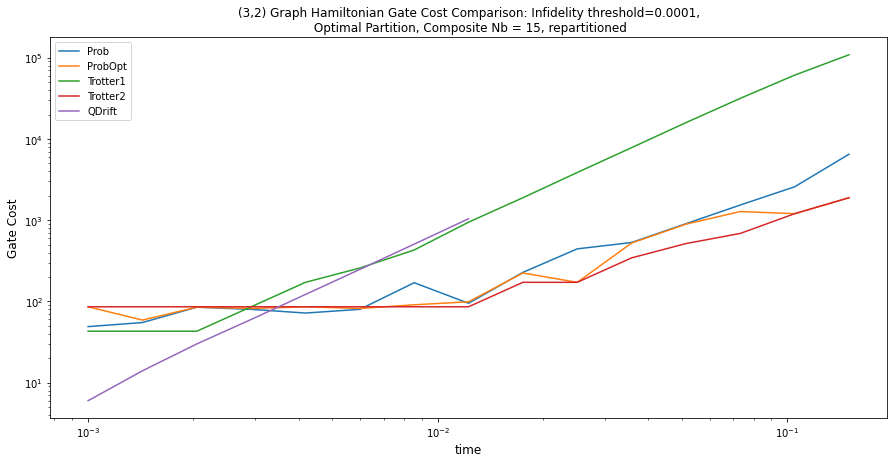

In [19]:
plt.figure(figsize = (15, 7))
plt.title("(3,2) Graph Hamiltonian Gate Cost Comparison: Infidelity threshold=0.0001,\n Optimal Partition, Composite Nb = 15, repartitioned")
plt.xlabel('time', size = 12)
plt.ylabel('Gate Cost', size = 12)
plt.loglog(times, list(CompSim_results.values()), label="Prob")
plt.loglog(times, list(CompSim2_results.values()), label="ProbOpt")
plt.loglog(times, list(TrotSim1_results.values()), label="Trotter1")
plt.loglog(times, list(TrotSim2_results.values()), label="Trotter2")
plt.loglog(times[:8], list(QDSim_results.values())[:8], label="QDrift")
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (15,) and (45,)

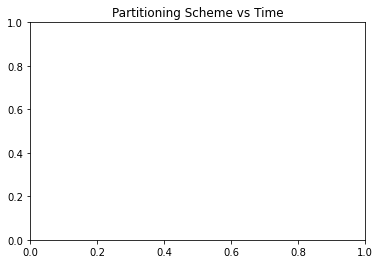

In [17]:
plt.title("Partitioning Scheme vs Time")
plt.plot(times, partition_dist[:,0], label="TrotterTerms")
plt.plot(times, partition_dist[:,1], label = "QDrift Terms")
plt.plot(times, nb_t, label = "nb")
plt.legend()
plt.show